In [40]:
import numpy as np
import pandas as pd
import json
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, timedelta
import matplotlib.dates as dates

In [41]:
import uncertainties.unumpy as unp
import uncertainties as unc

In [42]:
import geopandas as gpd

### Functions

In [43]:
def powerlaw(x, amplitude, exponent):
    return amplitude * x**(exponent)

In [44]:
def exponential(x, amplitude, tau):
    return amplitude * np.exp(x/tau)

In [45]:
def gauss(x, amplitude, mean, sigma):
    return amplitude*np.exp(-(x-mean)**2/(2*sigma**2))

### Import

In [46]:
dfr = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-regioni.json')
dfp = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-province.json')
df = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-andamento-nazionale.json')

In [47]:
dfp['data'] = pd.to_datetime(dfp['data'])
dfr['data'] = pd.to_datetime(dfr['data'])
df['data'] = pd.to_datetime(df['data'])

In [48]:
fr = 'italia/Limiti01012018_g/Reg01012018_g/Reg01012018_g_WGS84.shp'
mapr_df = gpd.read_file(fr)
mapr_df.loc[mapr_df.DEN_REG == 'Emilia-Romagna','DEN_REG'] = 'Emilia Romagna'

fp = 'italia/Limiti01012018_g/ProvCM01012018_g/ProvCM01012018_g_WGS84.shp'
mapp_df = gpd.read_file(fp)

#adding BZ and TN provinces to regions
mapr_df = mapr_df.append(mapp_df.loc[mapp_df.DEN_PCM == 'Trento', ['COD_RIP', 'COD_REG', 'Shape_Leng', 'Shape_Area',
       'geometry']], ignore_index=True, sort=True)
mapr_df.loc[20,'DEN_REG'] = 'P.A. Trento'

mapr_df = mapr_df.append(mapp_df.loc[mapp_df.DEN_PCM == 'Bolzano', ['COD_RIP', 'COD_REG', 'Shape_Leng', 'Shape_Area',
       'geometry']], ignore_index=True, sort=True)
mapr_df.loc[21,'DEN_REG'] = 'P.A. Bolzano'

In [49]:
dfpop = pd.read_csv('../model-DummyExp/dati_regioni.csv')

In [50]:
#dfp = dfp.set_index('denominazione_provincia').join(mapp_df.set_index('DEN_PCM').geometry)
#dfr = dfr.set_index('denominazione_regione').join(mapr_df.set_index('DEN_REG').geometry)

In [51]:
df.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
21,2020-03-16 17:00:00,ITA,11025,1851,12876,10197,23073,2470,2749,2158,27980,137962
22,2020-03-17 17:00:00,ITA,12894,2060,14954,11108,26062,2989,2941,2503,31506,148657
23,2020-03-18 17:00:00,ITA,14363,2257,16620,12090,28710,2648,4025,2978,35713,165541
24,2020-03-19 17:00:00,ITA,15757,2498,18255,14935,33190,4480,4440,3405,41035,182777
25,2020-03-20 17:00:00,ITA,16020,2655,18675,19185,37860,4670,5129,4032,47021,206886


# ITALIA

### f

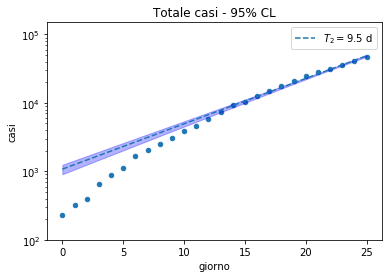

In [53]:
fig, ax = plt.subplots()

x = np.arange(len(df))
px = np.arange(len(df)*2)
dd = 0
last_day = len(df)

df.reset_index().plot.scatter(x='index',y='totale_casi', ax = ax, logy = True, title = 'Totale casi - 95% CL', ylim = [10**2,1.5*10**5])

popt, pcov = optimize.curve_fit(exponential, x[dd:], df.totale_casi[dd:])

y0,tau = unc.correlated_values(popt, pcov)
px = px[:last_day]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:last_day],exponential(px[:last_day], *popt), ls = '--', label = label)

#ax.scatter(17, exponential(17, *popt), color = 'red')
#ax.scatter(16,12462, color = 'red', label = 'today')

ax.set_xlabel('giorno')
ax.set_ylabel('casi')
ax.legend()
#print( max(df.data).date())
fig.savefig('plot/totale_casi_{}.png'.format(max(df.data).date()), dpi = 300)

### f'

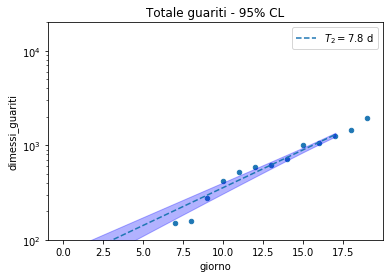

In [14]:
fig, ax = plt.subplots()

x = np.arange(len(df))
px = np.arange(len(df)*2)
dd = 6

df.reset_index().plot.scatter(x='index',y='dimessi_guariti', ax = ax, logy = True, title = 'Totale guariti - 95% CL', ylim=[10**2,2*10**4])

popt, pcov = optimize.curve_fit(exponential, x[dd:], df.dimessi_guariti[dd:])

y0,tau = unc.correlated_values(popt, pcov)
px = px[:18]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:18],exponential(px[:18], *popt), ls = '--', label = label)

#ax.scatter(17, exponential(17, *popt), color = 'red')
#ax.scatter(16,12462, color = 'red', label = 'today')

ax.set_xlabel('giorno')
ax.legend()
fig.savefig('plot/totale_guariti_{}.png'.format(max(df.data).date()), dpi = 300)

# Province

## Singola Provincia

In [ ]:
provincia = 'LO'

fig, ax = plt.subplots()

x = np.arange(19)
px = np.arange(20)
dd = 1

dfp[dfp.sigla_provincia == provincia].reset_index().reset_index().plot.scatter(x='level_0',y='totale_casi', ax = ax, logy = True, title = 'Totale casi {} - 95% CL'.format(provincia), ylim=[10**2,1.5*10**3])

popt, pcov = optimize.curve_fit(exponential, x[dd:], dfp[dfp.sigla_provincia == provincia].totale_casi[dd:])
y0,tau = unc.correlated_values(popt, pcov)
px = px[:18]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:18],exponential(px[:18], *popt), ls = '--', label = label)

#poptg, pcovg = optimize.curve_fit(gauss, x[:], dfp[dfp.sigla_provincia == provincia].totale_casi[:], p0=[1000,20,7])
#ax.plot(px[:16],gauss(px[:16], *poptg), ls = '--', label = 'gauss', color = 'red')

#ax.scatter(14, exponential(14, *popt), color = 'red')

ax.set_xlabel('giorno')
ax.legend()
fig.savefig('plot/totale_casi_{}.png'.format(provincia), dpi = 300)

In [ ]:
dfp[dfp.sigla_provincia == provincia].to_csv('pr.csv')

## Analisi Province

In [54]:
province = np.unique(dfp[dfp.sigla_provincia != ''].sigla_provincia.values)
regioni = np.unique(dfp[dfp.denominazione_regione != ''].denominazione_regione.values)

In [55]:
time = max(dfp.loc[:,'data'].values) + pd.Timedelta(days=1) #+ np.timedelta64(1,'D')

df_forecast = dfp[(dfp.data == max(dfp.data.values)) & (dfp.sigla_provincia != '')].copy()
df_forecast.loc[:,'data'] = time
sLength = len(df_forecast['data'])
df_forecast = df_forecast.assign(std = np.zeros(sLength))
#df_forecast.head()

In [56]:
for pr in province:
    df_temp = dfp[dfp.sigla_provincia == pr].copy()
    #df_temp.loc[:,'data'] = pd.to_datetime(df_temp.loc[:,'data'])
    df_temp.loc[:,'data'] = df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
    #df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
    
    try:
        x = df_temp[df_temp.totale_casi > 0].data.values - min(df_temp[df_temp.totale_casi > 0].data.values)
        y = df_temp[df_temp.totale_casi > 0].totale_casi.values
        popt, pcov = optimize.curve_fit(exponential, x, y)

        y0,tau = unc.correlated_values(popt, pcov)
        py = y0*unp.exp((max(x)+1)/tau)

        nom = py.nominal_value
        std_new = py.std_dev
    except:
        nom = 0
        std_new = 0
    
    df_forecast.loc[df_forecast.sigla_provincia == pr,['totale_casi','std']] = nom, std_new
    
    

In [58]:
df_forecast.to_csv('forecast_province_2020.03.21.csv')
df_forecast.totale_casi.sum()

57102.942402362074

In [59]:
merged = mapp_df.set_index('DEN_PCM').join(df_forecast.set_index('denominazione_provincia'))
merged['log_totale_casi'] = merged['totale_casi'].apply(lambda x: max(0,np.log10(x)))

In [60]:
merged.head()

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_PCM,DEN_PROV,DEN_CM,SIGLA,Shape_Leng,Shape_Area,...,stato,codice_regione,denominazione_regione,codice_provincia,sigla_provincia,lat,long,totale_casi,std,log_totale_casi
DEN_PCM,,,,,,,,,,,,,,,,,,,,,
Torino,1,1,1,201,201,-,Torino,TO,539249.812320,6.828137e+09,...,ITA,1.0,Piemonte,1.0,TO,45.073274,7.680687,1964.064829,60.957698,3.293156
Vercelli,1,1,2,0,2,Vercelli,-,VC,418249.269903,2.082028e+09,...,ITA,1.0,Piemonte,2.0,VC,45.323981,8.423234,246.471261,14.265563,2.391766
Novara,1,1,3,0,3,Novara,-,NO,250242.386669,1.341320e+09,...,ITA,1.0,Piemonte,3.0,NO,45.445885,8.621916,370.975347,14.864618,2.569345
Cuneo,1,1,4,0,4,Cuneo,-,CN,490111.881760,6.898443e+09,...,ITA,1.0,Piemonte,4.0,CN,44.393296,7.551172,280.811065,13.116046,2.448414
Asti,1,1,5,0,5,Asti,-,AT,315561.373435,1.508948e+09,...,ITA,1.0,Piemonte,5.0,AT,44.899129,8.204143,133.143924,5.786471,2.124321


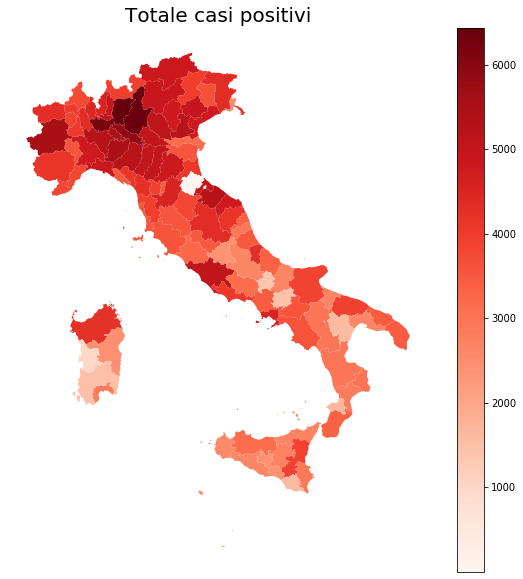

In [61]:
variable = 'log_totale_casi'
vmin, vmax  = min(merged[variable].values), max(merged[variable].values)
fig, ax = plt.subplots(1,figsize=(10,10))

merged.plot(column = variable, cmap = 'Reds', ax = ax);
ax.axis('off')
ax.set_title('Totale casi positivi', fontdict={'fontsize':'20'})
scale = plt.cm.ScalarMappable(cmap ='Reds', norm = plt.Normalize(vmin=10**vmin, vmax=10**vmax))
cbar = fig.colorbar(scale)
plt.savefig('map.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
for reg in regioni:
    province = df_forecast[df_forecast.denominazione_regione == reg].denominazione_provincia.values
    if len(province)>4:
        col = 3
    elif len(province)>2:
        col = 2
    else: 
        col = 1
    row = int(len(province)/col) + (len(province)%col > 0) 
    
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(12, 12), constrained_layout=True)
    day0, day1 = min(dfp.data.values) - np.timedelta64(1,'D'), max(dfp.data.values) + np.timedelta64(2,'D')

    if len(province)>1:
        for pr, ax in zip(province, axes.flat):
            x = df_forecast[(df_forecast.denominazione_provincia == pr)].data.values
            y = df_forecast[df_forecast.denominazione_provincia == pr].totale_casi.values
            yerr = 1.96*df_forecast[df_forecast.denominazione_provincia == pr]['std']
            ax.scatter(x,y, color = 'red', s = 30)
            ax.errorbar(x,y,yerr, color = 'red', alpha = 0.9)

            dfp[dfp.denominazione_provincia == pr].plot.scatter(x='data', y='totale_casi', ax = ax, title = pr, xlim =[day0,day1])
            locator = dates.AutoDateLocator(minticks=5, maxticks=7)
            formatter = dates.ConciseDateFormatter(locator)
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(formatter)
            ax.set_xlabel('')
            ax.set_ylabel('')
    else:
        x = df_forecast[df_forecast.denominazione_provincia == pr].data.values
        y = df_forecast[df_forecast.denominazione_provincia == pr].totale_casi.values
        yerr = 1.96*df_forecast[df_forecast.denominazione_provincia == pr]['std']
        axes.scatter(x,y, color = 'red', s = 30)
        axes.errorbar(x,y,yerr, color = 'red', alpha = 0.9)

        dfp[dfp.denominazione_provincia == pr].plot.scatter(x='data', y='totale_casi', ax = axes, title = pr, xlim =[day0,day1])
        locator = dates.AutoDateLocator(minticks=5, maxticks=7)
        formatter = dates.ConciseDateFormatter(locator)
        axes.xaxis.set_major_locator(locator)
        axes.xaxis.set_major_formatter(formatter)
        axes.set_xlabel('')
        axes.set_ylabel('')
        
    fig.suptitle('Regione ' + reg, size = 14)
    for i in range(len(province),row*col):
        fig.delaxes(axes.flat[i])
    fig.savefig('plot/Regione_'+reg+'_'+str(max(dfp.data).date())+'.png', dpi = 200)
    plt.close()

# Regioni

In [ ]:
time = max(dfr.loc[:,'data'].values) + pd.Timedelta(days=1) #+ np.timedelta64(1,'D')

dfr_forecast = dfr[(dfr.data == max(dfr.data.values)) & (dfr.denominazione_regione != '')].copy()
dfr_forecast.loc[:,'data'] = time
sLength = len(dfr_forecast)
dfr_forecast = dfr_forecast.assign(std = np.zeros(sLength))
dfr_forecast.head()

In [ ]:
columns = dfr_forecast.columns[6:16]
for col in columns:
    d = {}
    for reg in regioni:
        df_temp = dfr[dfr.denominazione_regione == reg].copy()
        #df_temp.loc[:,'data'] = pd.to_datetime(df_temp.loc[:,'data'])
        df_temp.loc[:,'data'] = df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
        #df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
        try:
            x = df_temp[df_temp[col] > 0].data.values - min(df_temp[df_temp[col] > 0].data.values)
            y = df_temp[df_temp[col] > 0].totale_casi.values
            popt, pcov = optimize.curve_fit(exponential, x, y)

            y0,tau = unc.correlated_values(popt, pcov)
            py = y0*unp.exp((max(x)+1)/tau)

            nom = py.nominal_value
            std_new = py.std_dev
        except:
            nom = 0
            std_new = 0
        d[reg] = [nom,std_new]
    dfr_forecast[col] = dfr_forecast.denominazione_regione.apply(lambda x: d[x][0])
    dfr_forecast['std_'+col] = dfr_forecast.denominazione_regione.apply(lambda x: d[x][1])

In [ ]:
dfr_forecast.to_csv('forecast_regioni_{}.csv'.format(max(dfr_forecast.data).date()))
dfr_forecast.totale_casi.sum()

In [39]:
df = pd.read_csv('../model-DummyExp/dati_regioni.csv')
#df.loc[df.denominazione_regione == 'Emilia Romagna','denominazione_regione'] = 'Emilia-Romagna'

#dfr_forecast.loc[dfr_forecast.denominazione_regione == 'Emilia Romagna','denominazione_regione'] = 'Emilia-Romagna'

In [51]:
mergedr = mapr_df.set_index('DEN_REG').join(dfr_forecast.set_index('denominazione_regione'))
mergedr = pd.concat([mergedr, merged[merged.DEN_PROV == 'Trento']])
mergedr = pd.concat([mergedr, merged[merged.DEN_PROV == 'Bolzano']])
mergedr = mergedr.rename(index = {'Trento': 'P.A. Trento', 'Bolzano': 'P.A. Bolzano'})
mergedr = mergedr.join(df.set_index('denominazione_regione')['popolazione'])

#mergedr.loc['P. A. Trento',:] = mergedr['Trento']
#mergedr.loc['P. A. Bolzano',:] = mergedr['Bolzano']

## Totale casi previsti

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]


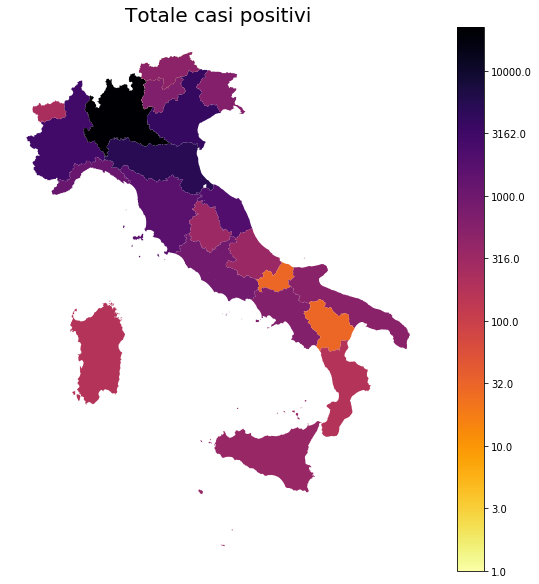

In [53]:
mergedr['log_totale_casi'] = mergedr['totale_casi'].apply(lambda x: max(0,np.log10(x)))
variable = 'log_totale_casi'
vmin, vmax  = min(mergedr[variable].values), max(mergedr[variable].values)
fig, ax = plt.subplots(1,figsize=(10,10))

mergedr.plot(column = variable, cmap = 'inferno_r', ax = ax, legend = True);
ax.axis('off')
ax.set_title('Totale casi positivi', fontdict={'fontsize':'20'})
#scale = plt.cm.ScalarMappable(cmap ='Blues', norm = plt.Normalize(vmin=vmin, vmax=vmax))
#cbar = fig.colorbar(scale)

colourbar = ax.get_figure().get_axes()[1]

# Get numerical values of yticks, assuming a linear range between vmin and vmax:
yticks = colourbar.get_yticks()
#yticks = np.interp(colourbar.get_yticks(), [0,1], [vmin, vmax])
print(yticks)

# Apply some function f to each tick, where f can be your percentage conversion
colourbar.set_yticklabels([round(10**ytick) for ytick in yticks])
plt.savefig('map_regioni{}.png'.format(max(dfr_forecast.data).date()), dpi = 300, bbox_inches = 'tight')

In [54]:
mergedr['log_perc_casi'] = mergedr[['totale_casi', 'popolazione']].apply(lambda x: np.log10(x[0]/x[1]), axis = 1)

In [55]:
mergedr['log_perc_casi'] 

Piemonte                -3.174348
Valle d'Aosta           -2.726996
Lombardia               -2.655062
Trentino-Alto Adige           NaN
Veneto                  -3.105324
Friuli Venezia Giulia   -3.302208
Liguria                 -3.118610
Emilia-Romagna          -2.919554
Toscana                 -3.352976
Umbria                  -3.446167
Marche                  -2.879889
Lazio                   -3.798836
Abruzzo                 -3.573914
Molise                  -4.023902
Campania                -3.976837
Puglia                  -3.904757
Basilicata              -4.282149
Calabria                -4.040239
Sicilia                 -4.151522
Sardegna                -3.957959
P.A. Trento             -2.927463
P.A. Bolzano            -3.030785
Name: log_perc_casi, dtype: float64

[-4.2 -4.  -3.8 -3.6 -3.4 -3.2 -3.  -2.8]


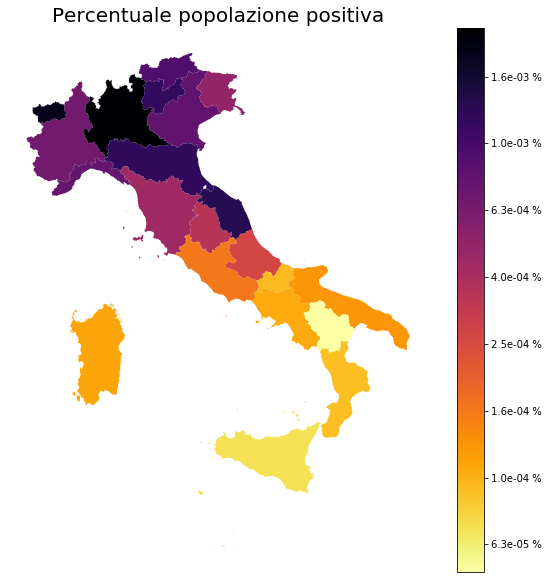

In [56]:
variable = 'log_perc_casi'
vmin, vmax  = min(mergedr[variable].values), max(mergedr[variable].values)
fig, ax = plt.subplots(1,figsize=(10,10))

mergedr.plot(column = variable, cmap = 'inferno_r', ax = ax, legend = True);
ax.axis('off')
ax.set_title('Percentuale popolazione positiva', fontdict={'fontsize':'20'})
#scale = plt.cm.ScalarMappable(cmap ='Blues', norm = plt.Normalize(vmin=vmin, vmax=vmax))
#cbar = fig.colorbar(scale)

colourbar = ax.get_figure().get_axes()[1]

# Get numerical values of yticks, assuming a linear range between vmin and vmax:
yticks = colourbar.get_yticks()
#yticks = np.interp(colourbar.get_yticks(), [0,1], [vmin, vmax])

# Apply some function f to each tick, where f can be your percentage conversion
colourbar.set_yticklabels(['{:3.1e} %'.format(10**ytick) for ytick in yticks])
#['{:5.2e}'.format(x) for x in leak] 
plt.savefig('map_perc_regioni{}.png'.format(max(dfr_forecast.data).date()), dpi = 300, bbox_inches = 'tight')

# Time evolution

In [81]:
day0, day1 = min(dfr.data), max(dfr.data)


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:13:

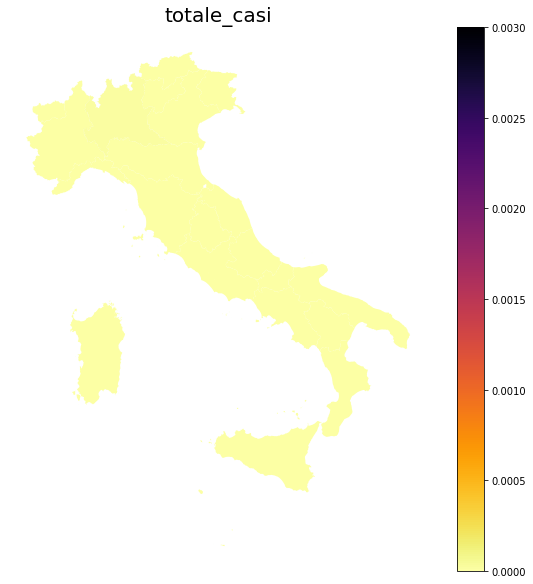

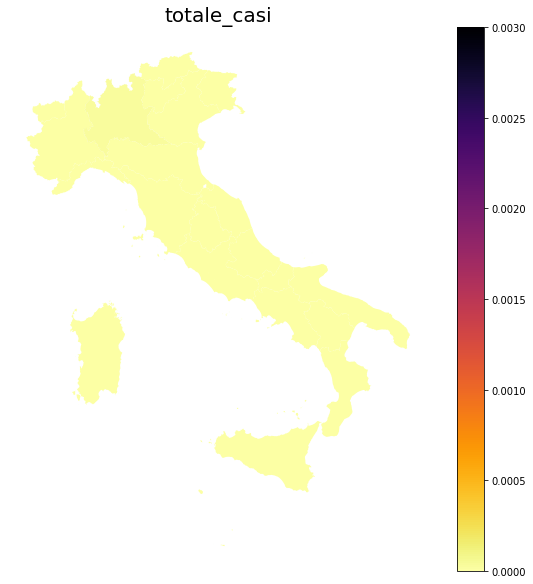

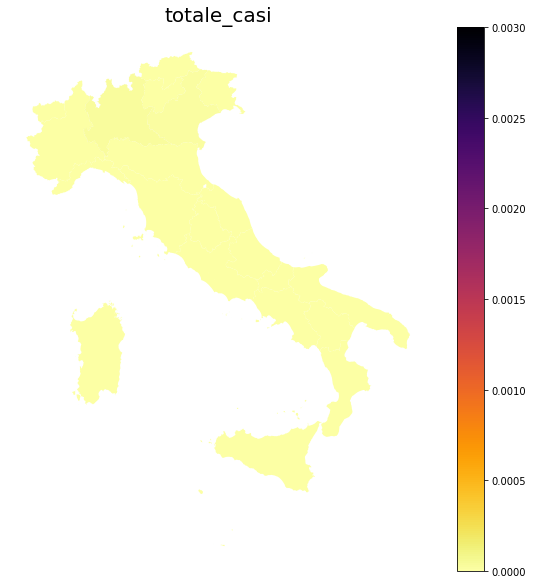

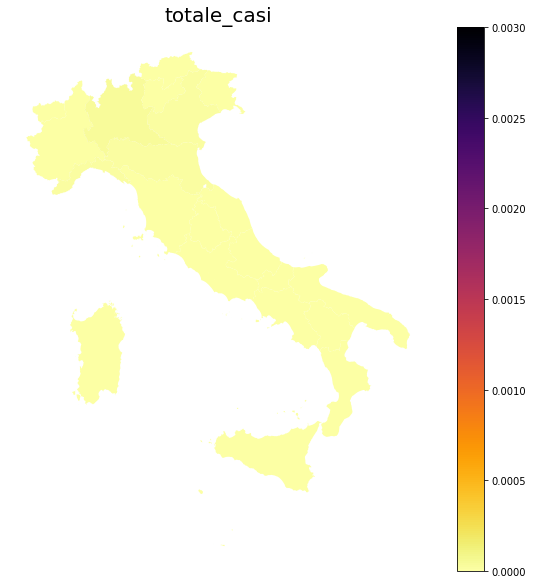

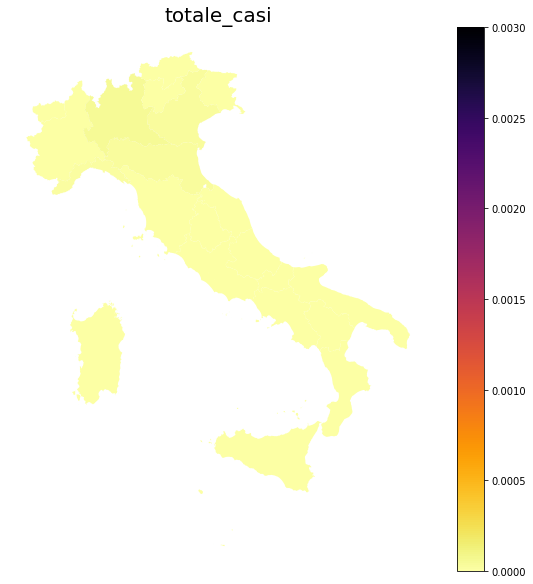

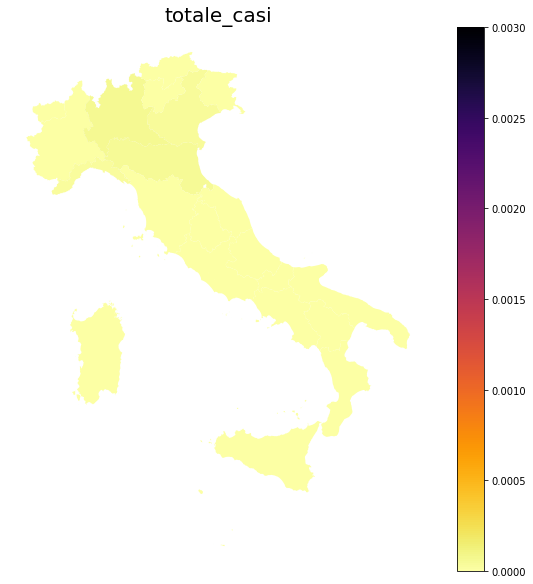

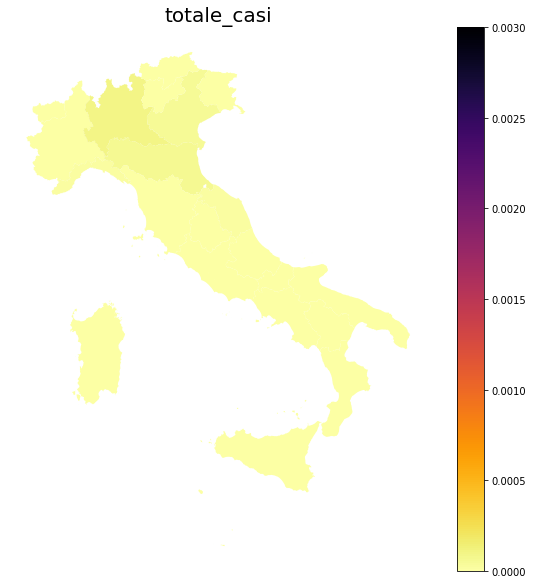

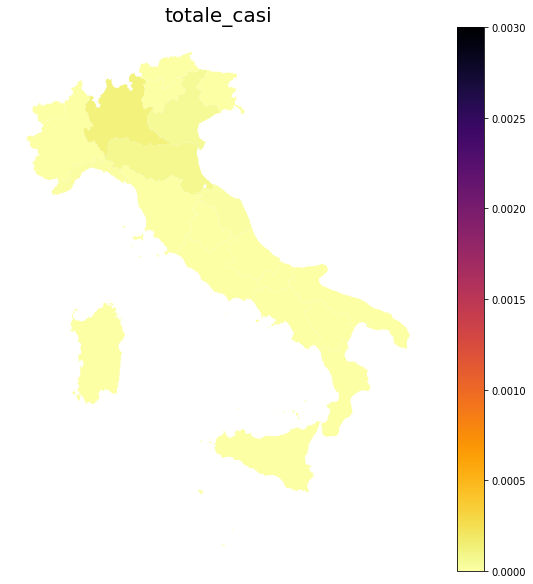

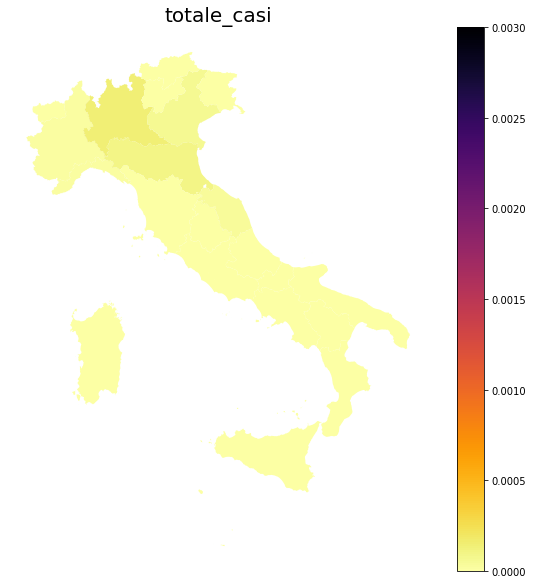

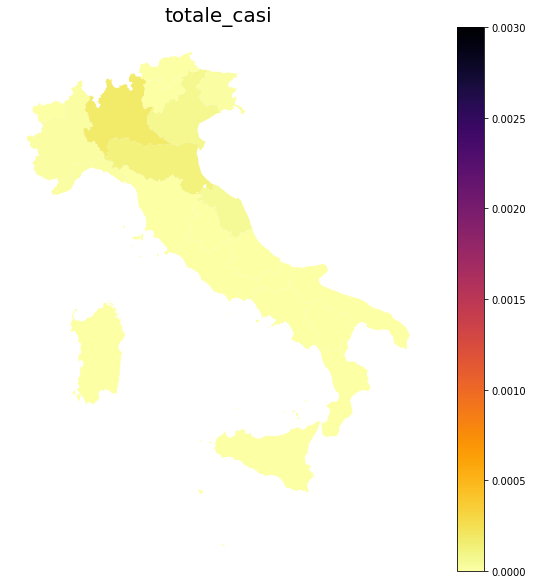

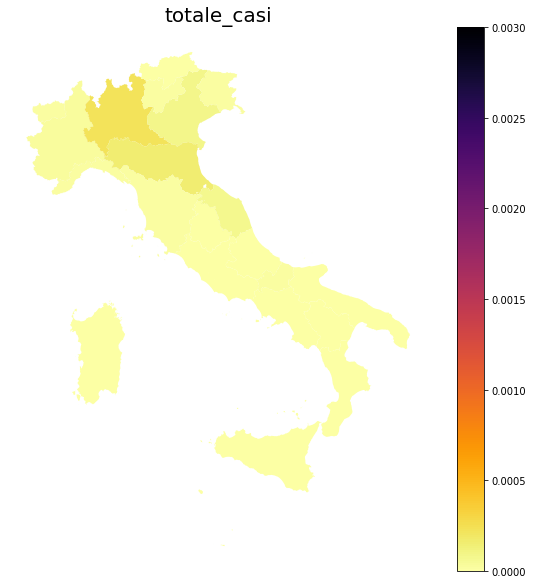

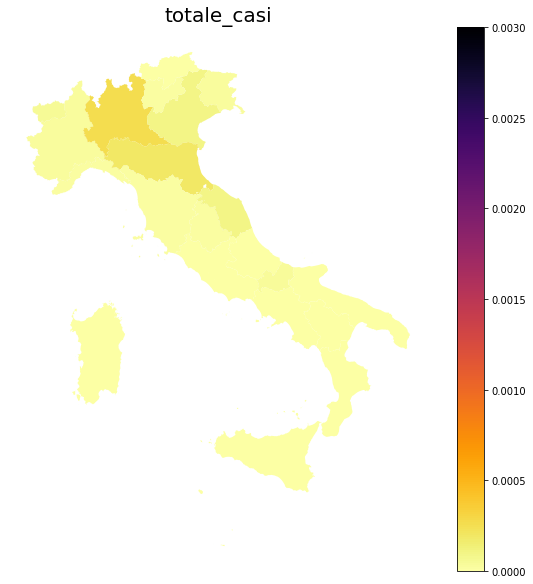

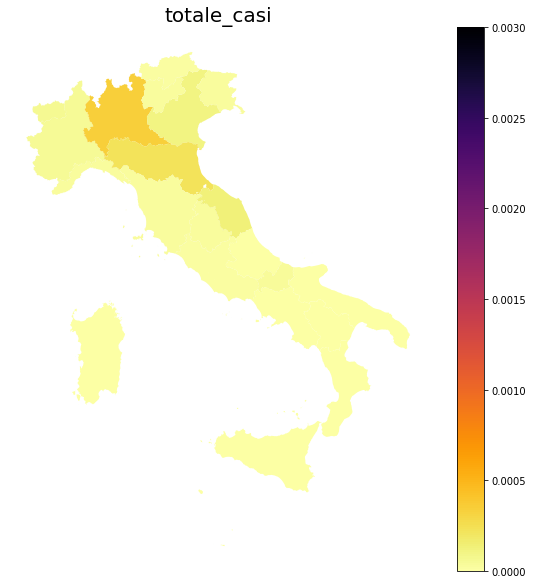

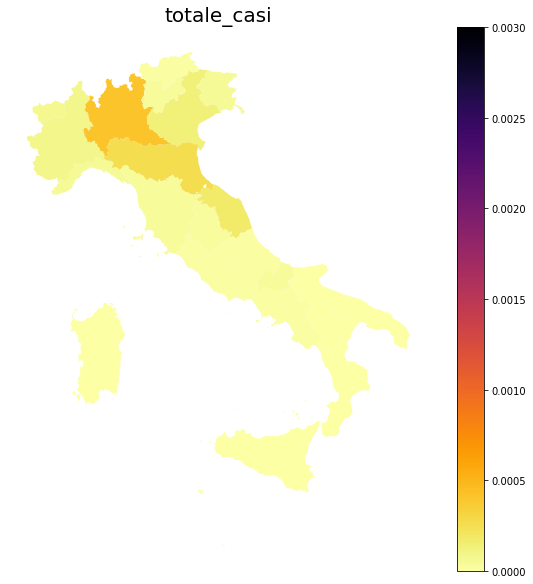

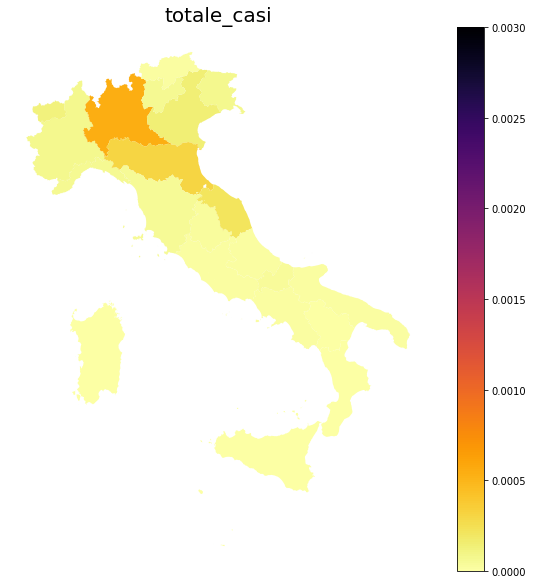

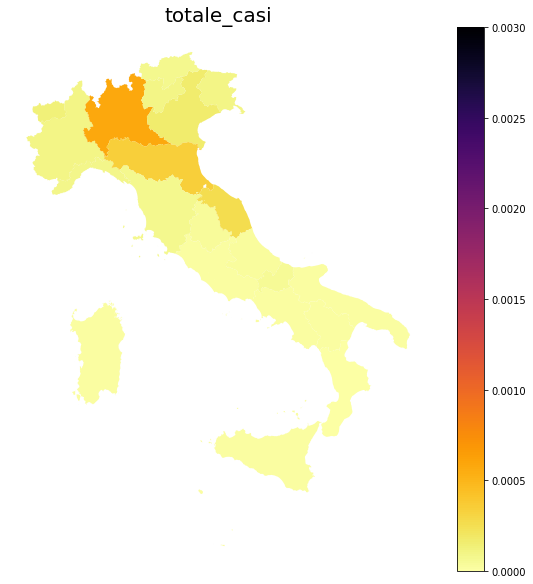

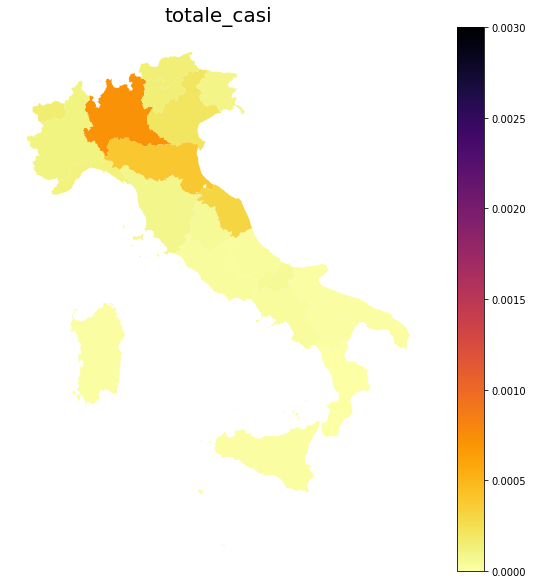

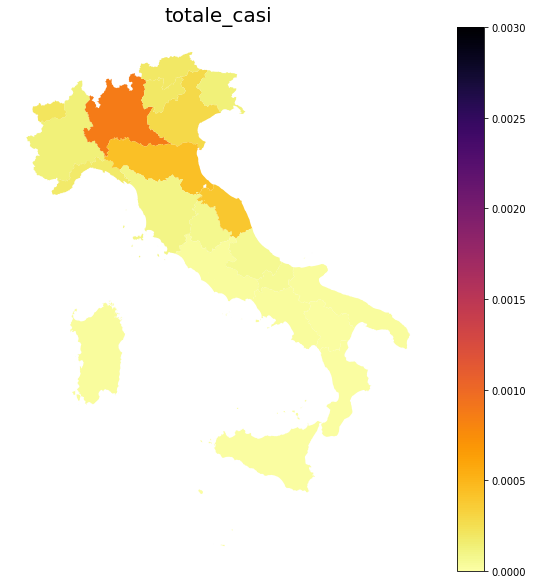

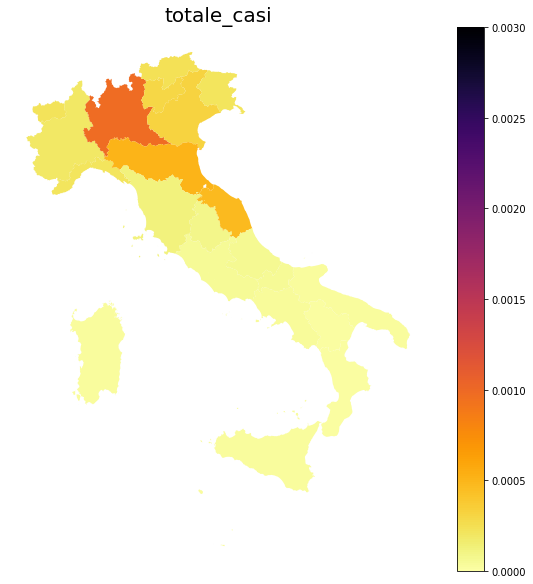

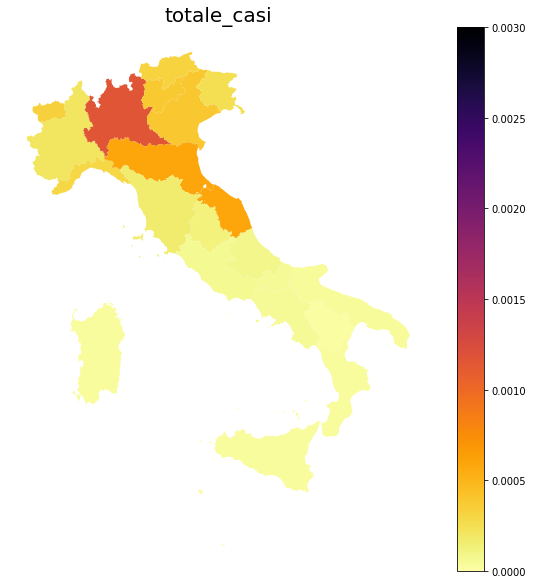

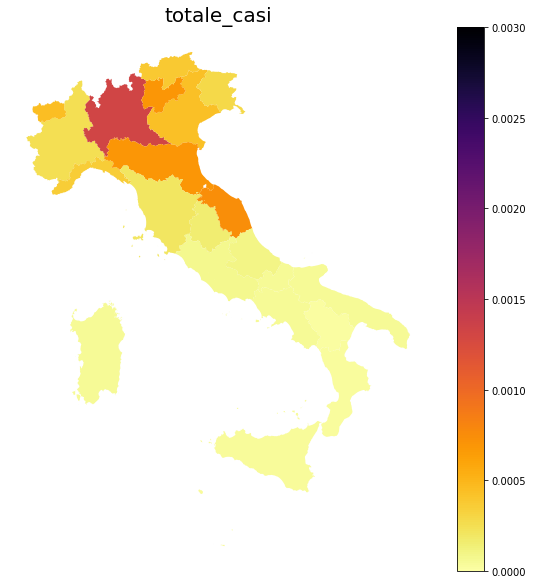

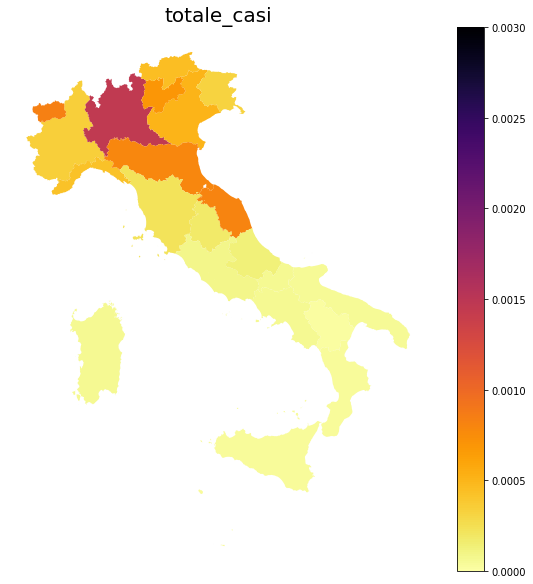

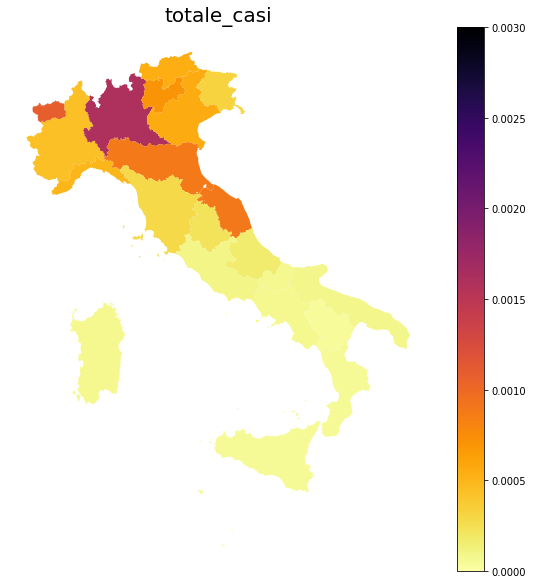

In [197]:
variable = 'totale_casi'
vmin, vmax  = min(dfr[variable].values), max(dfr[variable].values)
vmin, vmax = vmin, 0.003
ims = []

for d in pd.date_range(min(dfr.data), max(dfr.data)):
    fig, ax = plt.subplots(1,figsize=(10,10))
    dftemp = dfr[dfr.data.dt.date == d.date()].copy()
    mergedrr = mapr_df.set_index('DEN_REG').copy().join(dftemp.set_index('denominazione_regione'))
    mergedrr = mergedrr.join(dfpop.set_index('denominazione_regione')['popolazione'])
    mergedrr['perc_'+variable] = mergedrr[[variable, 'popolazione']].apply(lambda x: x[0]/x[1], axis = 1)
    mergedrr['log_'+variable] = mergedrr[variable].apply(lambda x: max(0,np.log10(x)))
    mergedrr['log_perc_'+variable] = mergedrr[[variable, 'popolazione']].apply(lambda x: np.log10(x[0]/x[1]), axis = 1)
    
    col = 'perc_'+variable
    ims.append([mergedrr.plot(column = col, cmap = 'inferno_r', ax = ax, legend = True, norm=plt.Normalize(vmin=vmin, vmax=vmax))]);
    ax.axis('off')
    ax.set_title(variable, fontdict={'fontsize':'20'})
    ax.set_xlabel('Day: {}'.format(d.date))
    plt.savefig('plot/geomap_'+col+'_'+str(d.date())+'.png')

In [ ]:
mergedr = mapr_df.set_index('DEN_REG').join(dfr[dfr.].set_index('denominazione_regione'))
mergedr = pd.concat([mergedr, merged[merged.DEN_PROV == 'Trento']])
mergedr = pd.concat([mergedr, merged[merged.DEN_PROV == 'Bolzano']])
mergedr = mergedr.rename(index = {'Trento': 'P.A. Trento', 'Bolzano': 'P.A. Bolzano'})
mergedr = mergedr.join(df.set_index('denominazione_regione')['popolazione'])

#mergedr.loc['P. A. Trento',:] = mergedr['Trento']
#mergedr.loc['P. A. Bolzano',:] = mergedr['Bolzano']